In [1]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, GRU, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2,l1
from keras.callbacks import EarlyStopping
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
import joblib

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



In [3]:
inputData = pd.read_csv("inputData.csv")
outputData = pd.read_csv("outputData.csv")

min_clip = 0.05
max_clip = 0.95

# Function to clip and interpolate a single column
def process_column(column):
    # Clip the values
    column = np.clip(column, min_clip, max_clip)
    
    # Interpolate using the mean of the values before and after
    column = column.interpolate(method='linear', limit_direction='both')
    
    return column

# Process each column in the input data
for column_name in inputData.columns:
    inputData[column_name] = process_column(inputData[column_name])

# Process each column in the output data
for column_name in outputData.columns:
    outputData[column_name] = process_column(outputData[column_name])

In [4]:
#Splitting the data on train and test
inputData_train, inputData_test, outputData_train, outputData_test = train_test_split(inputData, outputData, test_size=0.2)


#Scaling the data
inputScaler = StandardScaler()
outputScaler = MinMaxScaler()
inputScaler.fit(inputData_train)
outputScaler.fit(outputData_train)

scaled_inputData_train = inputScaler.transform(inputData_train)
scaled_inputData_test = inputScaler.transform(inputData_test)

scaled_outputData_train = outputScaler.transform(outputData_train)
scaled_outputData_test = outputScaler.transform(outputData_test)

print("Scaled Input Train data shape: ",scaled_inputData_train.shape)
print("Scaled Output Train data shape: ",scaled_outputData_train.shape)
print("---------------------------------------------")
print("Scaled Input Test data shape: ",scaled_inputData_test.shape)
print("Scaled Output Test data shape: ",scaled_outputData_test.shape)

Scaled Input Train data shape:  (57101, 64)
Scaled Output Train data shape:  (57101, 17)
---------------------------------------------
Scaled Input Test data shape:  (14276, 64)
Scaled Output Test data shape:  (14276, 17)


In [5]:
#Checking the shapes
inputShape = (scaled_inputData_train.shape[1],1)
outputShape = scaled_outputData_train.shape[1]
print(inputShape)
print(outputShape)
print(scaled_inputData_train.shape)
print(scaled_outputData_train.shape)

numOfEpochs = 150 #Umetnuti željeni broj epoha za trening modela
batchSize = 24 #Umetnuti željeni batch size
patineceForCallback = 20 #Ranije zaustavljanje treninga modela (koliko epoha strpljenja za isti rezultat)



(64, 1)
17
(57101, 64)
(57101, 17)


In [7]:
def build_GRU_Model(inputShape, outputShape):
    model = Sequential()
    model.add(GRU(units=128,activation='relu', return_sequences=True, 
                    input_shape=inputShape))
    model.add(Dropout(0.2))
    model.add(GRU(units=128,activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=128,activation='relu', return_sequences=True))
    model.add(GRU(units=128,activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(units=64,activation='relu'))
    model.add(Dense(units=outputShape, activation='linear'))
    return model

gruModel = build_GRU_Model(inputShape,outputShape)
gruModel.compile(optimizer='adam', loss='mean_squared_error')
gruModel.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=patineceForCallback, restore_best_weights=True)
gruModel.fit(scaled_inputData_train,scaled_outputData_train, epochs=numOfEpochs, batch_size=batchSize, validation_split=0.1, verbose=1, callbacks=[early_stopping])
scaled_GRU_prediction = gruModel.predict(scaled_inputData_test)
mae_GRU = mean_absolute_error(scaled_outputData_test, scaled_GRU_prediction)
mse_GRU = mean_squared_error(scaled_outputData_test, scaled_GRU_prediction)
rmse_GRU = np.sqrt(mse_GRU)
r2_GRU = r2_score(scaled_outputData_test,scaled_GRU_prediction)
print(f"Mean Absolute Error (MAE) of GRU: {mae_GRU:.4f}")
print(f"Mean Squared Error (MSE)of GRU: {mse_GRU:.4f}")
print(f"Root Mean Squared Error (RMSE)of GRU: {rmse_GRU:.4f}")
print(f"R-squared (R2) Score of GRU: {r2_GRU:.4f}")
gruModel.save("STD_MM_GRU_Model.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64, 128)           50304     
                                                                 
 dropout_3 (Dropout)         (None, 64, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 64, 128)           99072     
                                                                 
 dropout_4 (Dropout)         (None, 64, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 64, 128)           99072     
                                                                 
 gru_3 (GRU)                 (None, 64, 128)           99072     
                                                                 
 dropout_5 (Dropout)         (None, 64, 128)          

In [ ]:
def build_LSTM_Model(inputShape,outputShape):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=inputShape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64))
    model.add(Dense(units=outputShape, activation='linear'))
    return model
    
lstmModel = build_LSTM_Model(inputShape,outputShape)
lstmModel.compile(optimizer='adam', loss='mean_squared_error')
lstmModel.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)
lstmHistory = lstmModel.fit(scaled_inputData_train,scaled_outputData_train, epochs=numOfEpochs,batch_size=batchSize, 
                validation_split=0.1, verbose=1, callbacks=[early_stopping])
scaled_LSTM_prediction = lstmModel.predict(scaled_inputData_test)
mae_LSTM = mean_absolute_error(scaled_outputData_test, scaled_LSTM_prediction)
mse_LSTM = mean_squared_error(scaled_outputData_test, scaled_LSTM_prediction)
rmse_LSTM = np.sqrt(mse_LSTM)
r2_LSTM = r2_score(scaled_outputData_test,scaled_LSTM_prediction)
lstmModel.save("STD_MM_LSTM_Model.h5")

Model with pooling and dilation_rate=7, filter_size=256, optimizer=adam
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 62, 256)           1024      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 31, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 31, 256)           327936    
                                                                 
 conv1d_10 (Conv1D)          (None, 31, 256)           327936    
                                                                 
 conv1d_11 (Conv1D)          (None, 31, 256)           327936    
                                                                 
 conv1d_12 (Conv1D)          (None, 31, 256)    

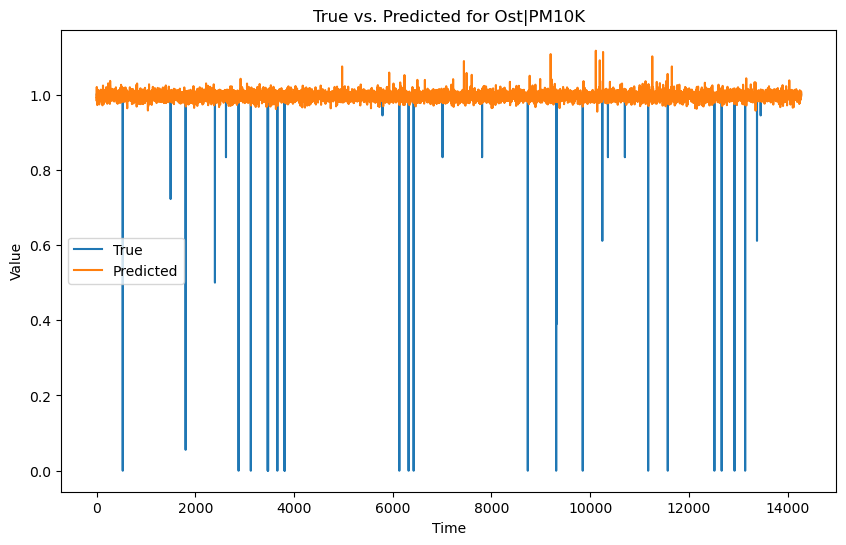

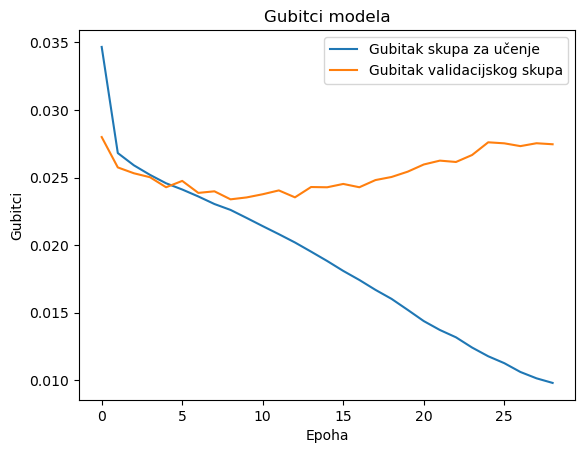

In [7]:
def build_wavenet_model_with_pooling(inputShape,outputShape,numOfDilatonLayers,numOfFilters,kernelSize):
    model = Sequential()
    # First layer
    model.add(Conv1D(filters=numOfFilters, kernel_size=kernelSize, activation='relu',input_shape=inputShape))
    model.add(MaxPooling1D(pool_size=2))    
    # Stack multiple dilation blocks
    dilation_rates = [2**i for i in range(numOfDilatonLayers)]
    for dilation_rate in dilation_rates:
        model.add(Conv1D(filters=numOfFilters, kernel_size=5,activation='relu', dilation_rate=dilation_rate, padding='causal'))
    # Last layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(outputShape, activation='linear'))  
    return model

dilationLayers = [7] #Umetnuti željene brojeve dilatacijskih slojeva 
filterSizes = [256] #Umetnuti željene veličine filtera
optimizers = ['adam'] #Umetnuti željene optimizatore (npr. 'adam','sgd','rmsprop')
kernelSize = 3
for optim in optimizers: 
    for numOfDilations in dilationLayers:
        for fSizes in filterSizes: 
            print("====================================================")
            print(f"Model with pooling and dilation_rate={numOfDilations}, filter_size={fSizes}, optimizer={optim}")
            print("====================================================")
            currentModel = build_wavenet_model_with_pooling(inputShape,outputShape,numOfDilations,fSizes,kernelSize)
            currentModel.compile(optimizer=optim, loss='mean_squared_error')
            currentModel.summary()
            early_stopping = EarlyStopping(monitor='val_loss', patience=patineceForCallback, restore_best_weights=True)
            history = currentModel.fit(scaled_inputData_train,scaled_outputData_train, epochs=numOfEpochs, batch_size=batchSize, 
                             validation_split=0.1, verbose=1, callbacks=[early_stopping])   
            scaled_prediction = currentModel.predict(scaled_inputData_test)
            mae = mean_absolute_error(scaled_outputData_test, scaled_prediction)
            mse = mean_squared_error(scaled_outputData_test, scaled_prediction)
            rmse = np.sqrt(mse)
            r2 = r2_score(scaled_outputData_test,scaled_prediction)

            print(f"Total Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Total Mean Squared Error (MSE): {mse:.4f}")
            print(f"Total Root Mean Squared Error (RMSE): {rmse:.4f}")
            print(f"Total R-squared (R2) Score: {r2:.4f}")

            targetedDataIndex = 2
            plt.figure(figsize=(10,6))
            plt.plot(scaled_outputData_test[:,targetedDataIndex], label ='True')
            plt.plot(scaled_prediction[:,targetedDataIndex], label='Predicted')
            plt.xlabel('Time')
            plt.ylabel('Value')
            plt.title('True vs. Predicted for Ost|PM10K')
            plt.legend()
            plt.show()
            
            plt.plot(history.history['loss'], label='Gubitak skupa za učenje')
            plt.plot(history.history['val_loss'], label='Gubitak validacijskog skupa')
            plt.title('Gubitci modela')
            plt.xlabel('Epoha')
            plt.ylabel('Gubitci')
            plt.legend()
            plt.show()
            
            currentModel.save(f"EXPANDED_ModelWithPooling_Dilation_rate={numOfDilations}Filter_size={fSizes}Kernel_size={kernelSize}_dilKernel=5Optimizer={optim}.h5")

In [10]:
############################################
    # Finding best RF Regression Model#
############################################
"""
parameterGrid = {
    'n_estimators': [100,200,300],
    'max_depth':[None, 10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'max_features':['sqrt','log2']
}
RFModel = RandomForestRegressor()
grid_search = GridSearchCV(estimator=RFModel, param_grid=parameterGrid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1,verbose=1)
grid_search.fit(scaled_inputData_train,scaled_outputData_train)
bestParametersRF = grid_search.best_params_
print("Best hyperparameters RF Regression Model: ", bestParametersRF)
best_RFModel = grid_search.best_estimator_
scaled_RF_prediction = best_RFModel.predict(scaled_inputData_test)
"""

RFModel = RandomForestRegressor(n_estimators=300, max_depth=None, max_features='sqrt', 
                                min_samples_leaf=1, min_samples_split=2)
RFModel.fit(scaled_inputData_train, scaled_outputData_train)
scaled_RF_prediction = RFModel.predict(scaled_inputData_test)
joblib.dump(RFModel,'RFModel.pkl')

['RFModel.pkl']

In [13]:
##############################################
    # Finding best XGBoost Regression Model#
##############################################
'''
parameterGrid = {
    'max_depth': range(3, 11),
    'min_child_weight': range(1, 6),
    'n_estimators': range(100, 1001, 100),
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

XGBModel = XGBRegressor()
grid_search = RandomizedSearchCV(estimator=XGBModel, param_distributions=parameterGrid,
                           n_iter=10, cv=5, scoring='neg_mean_squared_error',verbose=1)
grid_search.fit(scaled_inputData_train,scaled_outputData_train)
bestParametersXGB = grid_search.best_params_
print("Best hyperparameters for XGB Regression Model: ", bestParametersXGB)
best_XGBModel = grid_search.best_estimator_
'''
XGBModel = XGBRegressor(n_estimators=600, subsample=0.8,min_child_weight=4, max_depth=8,learning_rate = 0.05, gamma=0,colsample_bytree =0.9)
XGBModel.fit(scaled_inputData_train, scaled_outputData_train)
scaled_XGB_prediction = XGBModel.predict(scaled_inputData_test)
XGBModel.save_model('XGBModel.xgb')